# p-Center Problem
The p-center problem, as a traditional discrete location selection problem, has been applied widely in logistics, emergency facility location selection, and other fields.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Description" data-toc-modified-id="Problem-Description-1">Problem Description</a></span><ul class="toc-item"><li><span><a href="#p-Center" data-toc-modified-id="p-Center-1.1">p-Center</a></span></li><li><span><a href="#Integer-programming-model:" data-toc-modified-id="Integer-programming-model:-1.2">Integer programming model:</a></span></li></ul></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2">Setup</a></span></li><li><span><a href="#Examples" data-toc-modified-id="Examples-3">Examples</a></span><ul class="toc-item"><li><span><a href="#Case1.-Solving-p-Median-problem-with-synthetic-data" data-toc-modified-id="Case1.-Solving p-Median problem with synthetic data-3.1"> Case1. Solving p-Center problem with synthetic data</a></span></li><li><span><a href="#Road-Network-Data" data-toc-modified-id="Road-Network-Data-3.2">Case2. Solving p-Center problem with real-world data</a></span></li></ul></li></ul></div>

## Problem Description

### p-Center Problems <sup>[1]</sup>
It is assumed that there are a set of potential facilities points and a set of demand points. On the premise that the total number of facilities is fixed, determine where to build facilities and how to allocate demand points to facilities, so as to **minimize the sum of the maximum distance between demand points and allocated facilities.**

*Parameters*:
* **$I=1,...,n$** : Set of demand points
* **$J=1,...,m$** : Set of potential facility locations
* **$p$** : Number of facilities to be located

*Decision variables*:
$$x_{ij}=\begin{cases}1,&\text{if i is assigned to the facility j}\\ 0,&\text{otherwise}\end{cases}$$
$$y_j=\begin{cases}1,&\text{if and only if facility j is open}\\ 0,&\text{otherwise}\end{cases}$$


###  Integer programming model:
$$
\begin{array}{lll}
\text{Min} & \sum_{j=1}^{n}d_{ij}x_{ij} & (1) \\
\text{s.t.} & \sum_{j=1}^{n}y_j=p, & (2)\\
& \sum_{j=1}^{n}x_{ij}=1,i=1,...,n, & (3)\\
& x_{ij}≤y_{j},i=1,...n,j=1,...n, & (4)\\
& \sum_{j=1}^{n}d_{ij}x_{ij}≤z,i=1,...n, & (5)\\
& x_{ij}≤y_{j}∈\{0,1\},i=1,...n,j=1,...n. & (6)\\
\end{array}
$$


Equation (2) ensure that the number of open facilities is p. Constraints (3) assign each demand points to only one facility. Inequalities (4) guarantee each demand points must assign to a open facility. Constraints (5) require that $z$ is the upper bound of the distance between any demand points to the assigned facility. 
It is easy to see that $z=max_{i=1,...,n}\sum_{j=1}^n d_{ij}x_{ij}$ is the optimal cover radius.


[1] Hakimi S L. Optimum locations of switching centers and the absolute centers and medians of a graph[J]. Operations research, 1964, 12(3): 450-459.

## Setup

### Set up the environment by importing libraries
import numpy, pulp, matplotlib, pandas and Hispot libraries to set up an environment

In [1]:
import random
import numpy as np
import pandas as pd
from pulp import *
import matplotlib.pyplot as plt
from hispot.FLP import PCenter

PuLP is an open source linear programming package (actually also includes integer programming). You can use `pip install pulp` to start. 

PuLP supports many open-source linear programming solvers, such as `CBC` and `GLPK`. In addition, PuLP also supports commercial solvers such as `Gurobi` and IBM's `CPLEX`. Notice: these commercial solvers might need licenses to deal with the large-scale problem.  
The default solver after installing PuLP is CBC. This open-source solver from COIN-OR is sufficient for solving most problems.
You can use `listSolvers(onlyAvailable=True)` to check the other available solvers.

In [2]:
np.random.seed(0) # random seed
solver_list = listSolvers(onlyAvailable=True)
print(solver_list) 

['GUROBI_CMD', 'PULP_CBC_CMD']


## Examples

In this part, we will input synthetic data and real-world data and display them as two examples to represent random cases and real-world scenarios, respectively.

### Case1. Solving p-Center problem with synthetic data

Generate problem with synthetic data

In [3]:
num_points = 50  # P: number of demand points
num_located = 8  # P: number of located facility
np.random.seed(0)
points = [(random.random(), random.random()) for i in range(num_points)]
points_np = np.array(points)


Output optimal solution

In [4]:
%time
centers, assigns, obj = PCenter(num_points=num_points,
                                points=points_np,
                                solver=PULP_CBC_CMD(),
                                num_located=num_located).prob_solve()

CPU times: total: 0 ns
Wall time: 0 ns
Status: Optimal
Centers = [3, 6, 29, 31, 36, 37, 41, 47]
Assigned relationships =  {3: [10, 45], 6: [0, 34, 43], 29: [7, 19, 35], 31: [23, 28, 33, 42, 46], 36: [2, 4, 8], 37: [11, 12, 13, 17, 29, 39, 49], 41: [1, 9, 16, 21, 22, 26, 27, 32, 38, 40, 48], 47: [5, 14, 15, 18, 20, 24, 25, 30, 44]}
Minimum Maximum distance =  0.22816668


Visualize optimal solution

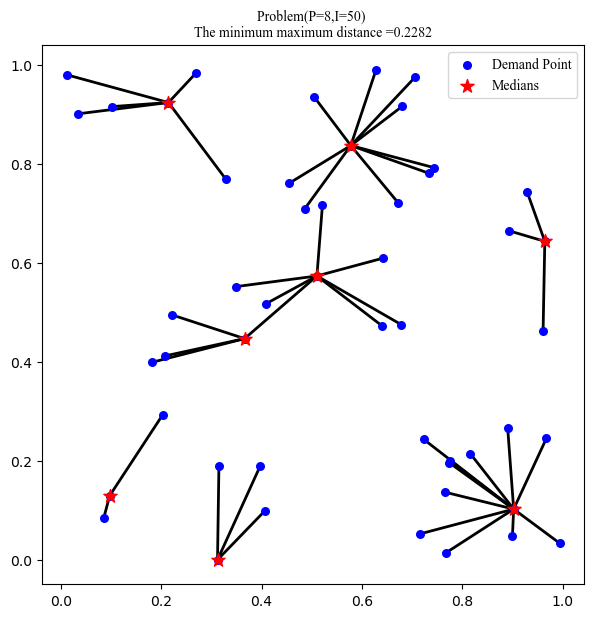

In [5]:
plt.figure(figsize=(7,7))
name = 'Problem(P=' + str(num_located) + ',I=' + str(num_points) + ') \nThe minimum maximum distance =' + str(round(obj,4))
plt.title(name, fontsize = 15,font = 'Times New Roman')

#Points
plt.scatter(*zip(*points_np), c='Blue', marker='o',s=30, label = 'Demand Point', zorder=2)
plt.scatter(*zip(*points_np[centers]), c='Red', marker='*',s=100,label = 'Medians',zorder=3)
#Lines
for i in assigns:
    center_point = points_np[i]
    for j in assigns[i]:
        demand_points = points_np[j]
        pts = [points[i], points[j]]
        plt.plot(*zip(*pts), c='Black', linewidth=2, zorder=1)
# plt.grid(True)   
plt.legend(loc='best',prop='Times New Roman',fontsize=12)
plt.show()

### Case2. Solving p-Center problem with real-world data

Import `geopandas`, `geoplot` to process geographic data and plot map

In [6]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from math import *

We select Changping District of Beijing the study area and read partial poi points in Tongzhou District.

In [21]:
%%time
region=gpd.read_file("../data/beijing/tongzhou/tongzhou.shp")
region.head(2)

CPU times: total: 15.6 ms
Wall time: 15.2 ms


,ID,geometry
0,1,"POLYGON ((116.72342 39.64957, 116.72231 39.649..."
1,2,"POLYGON ((116.70262 39.73924, 116.69795 39.736..."


Partial POI data in Changping district

In [22]:
%%time
poi = gpd.read_file("../data/beijing/tongzhou/tongzhou-poi.shp")

CPU times: total: 15.6 ms
Wall time: 28.5 ms


In [23]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

Visualization of the input data by geoplot

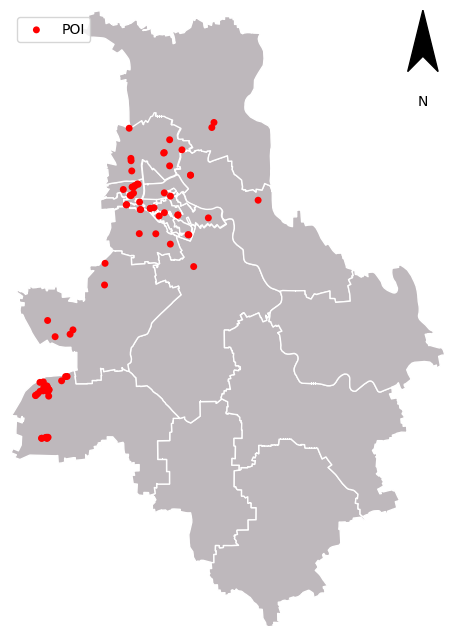

In [25]:
ax = gplt.polyplot(region,
                   projection=gcrs.AlbersEqualArea(),
                   edgecolor="white", facecolor="#BEB8BC",
                   figsize=(10, 8))
gplt.pointplot(poi, 
               extent=region.total_bounds,
               s=5,
               color='red',
               alpha=1,
               linewidth=0,
               label='POI',
               ax=ax)
plt.legend(loc='upper left')
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.05,ratio = 0.7)

Generate problem with real-world data

In [30]:
def get_coordinate(longitude, latitude):
    # lo is the longitude of the location;
    # la is the latitude of the location;

    # coordinate transformation
    R = 6537
    lo = np.mean(longitude)
    la = np.mean(latitude)
    x = R*(longitude-lo)*cos(la)
    y = R*(latitude-la)
    return x,y

In [33]:
data = poi[['lon', 'lat']]
num_points = poi.shape[0]
num_located = 7
x,y=get_coordinate(data['lon'], data['lat'])
pointsxy = [(x[i], y[i]) for i in range(num_points)] # x,y
pointsxy_np = np.array(pointsxy)
points = [(data['lon'][i],data['lat'][i]) for i in range(num_points)] 
points_np = np.array(points)

Output optimal solution

In [34]:
centers, assigns, obj = PCenter(num_points=num_points,
                                points=pointsxy_np,
                                solver=PULP_CBC_CMD(),
                                num_located=num_located).prob_solve()

Status: Optimal
Centers = [2, 9, 11, 27, 32, 48, 51]
Assigned relationships =  {2: [10, 12, 13, 18, 21, 22, 23, 57, 65, 69], 9: [], 11: [6, 15, 16, 36, 43], 27: [3, 4, 14, 17, 19, 20, 25, 29, 30, 38, 42, 45, 46, 47, 52, 53, 58, 61, 62, 66, 70, 74, 75, 76], 32: [0, 8, 24, 28, 31, 34, 35, 37, 39, 40, 41, 50, 54, 55, 59, 60, 64, 67, 68, 71, 72, 77], 48: [5, 7, 26, 33, 44, 56, 63, 73], 51: [1, 49]}
Minimum Maximum distance =  197.7222


prepare the LineString and center Points to plot the solution

In [35]:
from shapely.geometry import LineString
crs = 'EPSG:4326'
lines = gpd.GeoDataFrame(columns=['id', 'geometry'], crs=crs)
k = 0
for i in assigns:
    center = points_np[i]
    for j in assigns[i]:
        assign = points_np[j]
        line = LineString([center, assign])
        lines.loc[k] = [k+1, line]
        k = k+1
center_points = poi.iloc[centers]

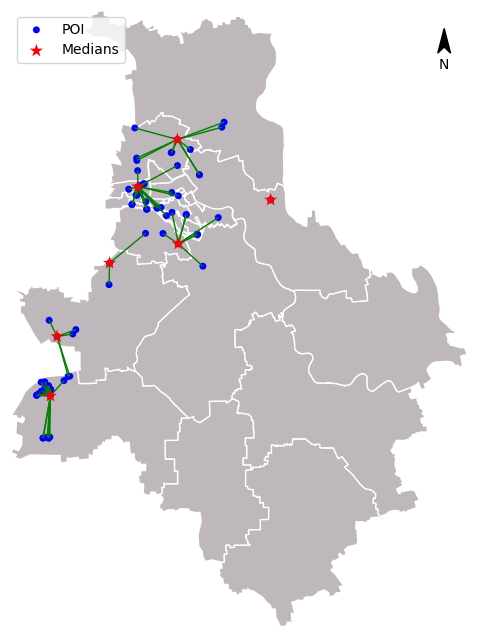

In [36]:
ax = gplt.sankey(lines, 
                 projection=gcrs.Mollweide(),
                 linewidth=1,
                 color='green',
                 zorder=3,
                 figsize=(10, 8),)
gplt.polyplot(region,
              projection=gcrs.AlbersEqualArea(),
              edgecolor="white", 
              facecolor="#BEB8BC",
              zorder=1,
              ax=ax,)
gplt.pointplot(poi, 
               extent=region.total_bounds,
               s=5,
               color='blue',
               alpha=1,
               linewidth=0,
               label='POI',
               zorder=2,
               ax=ax)
gplt.pointplot(center_points, 
               extent=region.total_bounds,
               s=10,
               color='red',
               alpha=1,
               linewidth=0,
               marker='*',
               label='Medians',
               zorder=4,
               ax=ax)
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.02,ratio = 0.7)
plt.legend(loc='upper left')